# U1T3 - Medicines and Assortativity

## Overview

This notebook uses a open dataset from the Brazilian Health Regulatory Agency (ANVISA) regarding the registration of medicines in the country. In this assignment the goal is to use the data to test some hypotheses brought up by the professor and use the concept of graph assortativity to try to accept or reject them.

## Browse
* [Data](#the-data)
* [Networks](#the-networks)
    * [Hypothesis #1](#hypothesis-#1)
    * [Hypothesis #2](#hypothesis-#2)
    * [Hypothesis #3](#hypothesis-#3)

## The Data

The data comes as part of the Datavisa system for Data Intelligence and shows the registration information about medicines in Brazil. For the sake of this assignment, we'll focus only on the subset of active/valid registries and work with information about the company, the regulatory category, the therapeutic class and active ingredients for each medicine to empower us to draw some conclusions about the hypotheses posed.

In [1]:
import networkx as nx
import nxviz as nv
from nxviz import annotate, highlights
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
# Load the data
df = pd.read_csv('assets/DADOS_ABERTOS_MEDICAMENTOS.csv', encoding='latin1', sep=';')

In [3]:
# We will work only with registries that are valid or active
print(df.SITUACAO_REGISTRO.value_counts())

df = df[df['SITUACAO_REGISTRO'] != 'CADUCO/CANCELADO']
df = df[['NOME_PRODUTO','CATEGORIA_REGULATORIA', 'CLASSE_TERAPEUTICA', 'EMPRESA_DETENTORA_REGISTRO', 'PRINCIPIO_ATIVO']]

#  Removes NaN values and then splits and strips the active ingredients and therapeutic class columns
df = df.dropna()

df['PRINCIPIO_ATIVO'] = df['PRINCIPIO_ATIVO'].str.split('+').apply(lambda x: [i.strip() for i in x])
df['CLASSE_TERAPEUTICA'] = df['CLASSE_TERAPEUTICA'].str.split('+').apply(lambda x: [i.strip() for i in x])

# Reset the index so
df.reset_index(drop=True, inplace=True)

SITUACAO_REGISTRO
CADUCO/CANCELADO    19585
VÁLIDO              11732
ATIVO                  62
Name: count, dtype: int64


## Networks



### Hypothesis #1

The first hypothesis we dive in is related with the likelihood of medicines that are in the same regulatory category share at least one active ingredient, i.e., are connected in the graph.

H1 is an undirected graph that have the properties we desire. The assortativity coefficient for H1 based on `reg_category` will aid us in reaching a result.

In [4]:
H1 = nx.Graph()

for i, row in df.iterrows():
    H1.add_node(i,
                name=row['NOME_PRODUTO'],
                reg_category=row['CATEGORIA_REGULATORIA'],
                active_ingredient=set(row['PRINCIPIO_ATIVO'])
    )

for node, attr in list(H1.nodes(data=True)):
    for other_node, other_attr in list(H1.nodes(data=True)):
        if node != other_node:
            if attr['active_ingredient'] & other_attr['active_ingredient']:
                H1.add_edge(node, other_node)

In [5]:
assortativity_by_reg_cat = nx.attribute_assortativity_coefficient(H1, 'reg_category')
print(assortativity_by_reg_cat)

0.22265054610005705


This graph's assortativity indicates that medicines in the same regulatory category are more likely to share active ingredients than with medicines in other groups. This tendency is not as strong, but exists still.

### Hypothesis #2

This second network consists in a bipartite graph with medicines on one set and active ingredients on the other. The goal here is to test if medicines with high variety of active ingredients are somehow more connected by means of their active ingredients to other medicines with similar complexity.

In [6]:
H2 = nx.Graph()

for i, row in df.iterrows():
    H2.add_node(i, name=row['NOME_PRODUTO'], type='medicine')
    for active_ingredient in row['PRINCIPIO_ATIVO']:
        H2.add_node(active_ingredient, type='active_ingredient')
        H2.add_edge(i, active_ingredient)


In [8]:
degrees = dict(H2.degree)
# Edge-centric plot
edge_assort = [(degrees[e[0]], degrees[e[1]]) for e in H2.edges]
edge_assort = pd.DataFrame(data = edge_assort, columns = ("k1", "k2"))
edge_assort = edge_assort.groupby(by = ["k1", "k2"]).size().reset_index().rename(columns = {0: "count"}).sort_values(by = "count")
# Taking the log count of edges with nodes with the same degrees
edge_assort["count"] = np.log(edge_assort["count"])

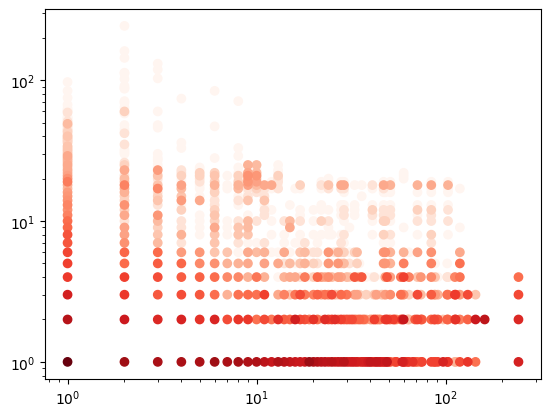

In [9]:
ax = plt.gca()
plt.scatter(edge_assort["k1"], edge_assort["k2"], c = edge_assort["count"], cmap = "Reds")
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

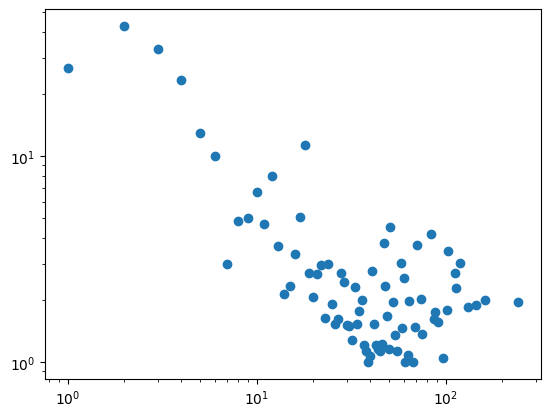

In [10]:
node_assort = [(degrees[n], degrees[n2]) for n in H2.nodes for n2 in H2.neighbors(n)]
node_assort = pd.DataFrame(data = node_assort, columns = ("k", "neigh_k"))
node_assort = node_assort.groupby(by = "k").mean().reset_index()
# Plotting the node-centric plot
ax = plt.gca()
plt.scatter(node_assort["k"], node_assort["neigh_k"])
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

In [11]:
assortativity_by_degree = nx.degree_assortativity_coefficient(H2)
print(assortativity_by_degree)

-0.23304218456948902


For this experiment, the negative coefficient means that according to degree, the medicines that have many active ingredients associates with active ingredients presents in medicines of lower complexity.

### Hypothesis #3

The final network aims to answer the following question: are the medicines from the same company or therapeutic class more likely to have active ingredients in common? For this, the H3 graph will be helpful.

In [15]:
H3 = nx.Graph()

for i, row in df.iterrows():
    H3.add_node(i,
                name=row['NOME_PRODUTO'],
                therapeutic_class=row['CLASSE_TERAPEUTICA'],
                company=row['EMPRESA_DETENTORA_REGISTRO'],
                active_ingredient=set(row['PRINCIPIO_ATIVO']),
    )

for node, attr in list(H3.nodes(data=True)):
    for other_node, other_attr in list(H3.nodes(data=True)):
        if node != other_node:
            if attr['active_ingredient'] & other_attr['active_ingredient']:
                H3.add_edge(node, other_node)

In [22]:
assortativity_by_company = nx.attribute_assortativity_coefficient(H3, 'company')

print('Assortativity by company:', assortativity_by_company)

Assortativity by company: 0.01749924676873968


An assortativity coefficient near 0 like the one we got for 'company' suggests that company of origin has little to no effect in active ingredients sharing. The node connections are nearly random, with very weak or negligible correlation in terms of the attribute analyzed.